# GradCAM - Gradient Class Activation Map

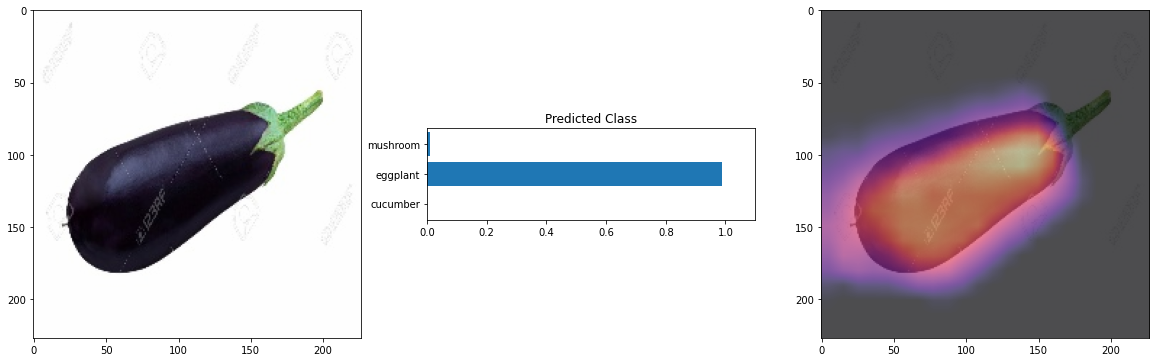

In [1]:
!git clone https://github.com/parth1620/GradCAM-Dataset.git 
!pip install -U git+https://github.com/albumentations-team/albumentations 
!pip install --upgrade opencv-contrib-python 

Cloning into 'GradCAM-Dataset'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 193 (delta 0), reused 193 (delta 0), pack-reused 0
Receiving objects: 100% (193/193), 2.59 MiB | 9.67 MiB/s, done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-2lezt8tb
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-2lezt8tb
  Resolved https://github.com/albumentations-team/albumentations to commit 2a1826d49c9442ae28cf33ddef658c8e24505cf8
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-1.3.0-py3-none-any.whl size=124568 sha256=445567511e621ea649fa637ad80649d749d379da46fea4d1b1fbffdb4780a301
  Stored in directory: /tmp/pip-ephem-wheel

# Imports

In [2]:
import sys 
sys.path.append('/content/GradCAM-Dataset')

In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import cv2

import torch 
from torch import nn 
import torch.nn.functional as F 

from torch.utils.data import DataLoader, Dataset 
from torchvision import datasets, transforms as T

from tqdm import tqdm 
import albumentations as A 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import utils

# Configurations

In [4]:
CSV_FILE =  '/content/GradCAM-Dataset/train.csv'
DATA_DIR = '/content/GradCAM-Dataset/'

DEVICE = 'cuda'
BATCH_SIZE = 16
LR = 0.001
EPOCHS = 20

In [5]:
data = pd.read_csv(CSV_FILE)
data.head()

,img_path,label
0,train_images/mushroom_51.jpg,2
1,train_images/eggplant_37.jpg,1
2,train_images/mushroom_20.jpg,2
3,train_images/eggplant_51.jpg,1
4,train_images/eggplant_26.jpg,1


In [6]:
#cucuber - 0, eggplant -1, mushroom -2

train_df, valid_df = train_test_split(data, test_size = 0.2, random_state =42)

# Augmentations

In [7]:
train_augs = A.Compose([A.Rotate(),
                        A.HorizontalFlip(p=0.5),
                        A.VerticalFlip(p=0.5),
                        A.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.255])
])

valid_augs = A.Compose([
                      A.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.255])
])


# Load Image Dataset 

In [8]:
trainset =utils.ImageDataset(train_df, augs = train_augs, data_dir = DATA_DIR)
validset =utils.ImageDataset(valid_df, augs = valid_augs, data_dir = DATA_DIR)

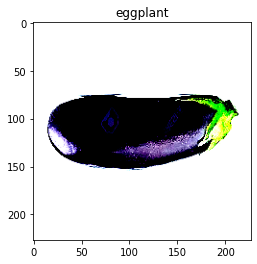

In [9]:
image, label = trainset[0] #(c,h,w) -> (h,w,c)
class_list = ['cucumber', 'eggplant', 'mushroom']
plt.imshow(image.permute(1,2,0))
plt.title(class_list[label]);

In [10]:
print(f"No. of examples in the {len(trainset)}")
print(f"No. of examples in the {len(validset)}")

No. of examples in the 148
No. of examples in the 38


# Load Dataset into Batches

In [11]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [12]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 10
No. of batches in validloader : 3


In [13]:
for images, labels in trainloader:
  break

print(f"One batch image shape : {images.shape}")
print(f"One batch label shape : {labels.shape}")

One batch image shape : torch.Size([16, 3, 227, 227])
One batch label shape : torch.Size([16])


# Create Model 

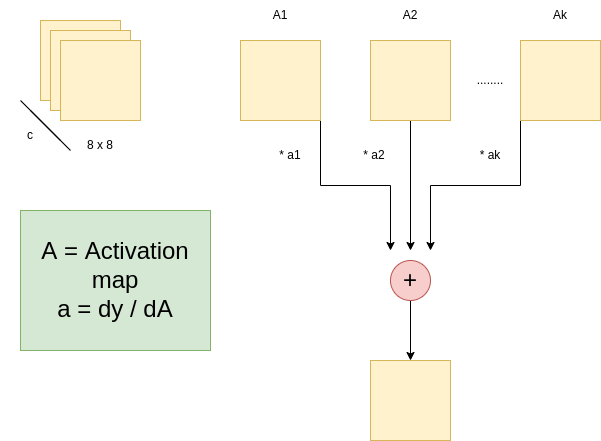

In [30]:
class ImageModel(nn.Module):
  def __init__(self):
    super(ImageModel, self).__init__()

    self.feature_extractor = nn.Sequential(
        nn.Conv2d(in_channels =3, out_channels =16, kernel_size = (5,5), padding =1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size =(4,4), stride = 2),
        nn.Conv2d(in_channels =16, out_channels =16, kernel_size = (5,5), padding =1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size =(4,4), stride = 2),
        nn.Conv2d(in_channels =16, out_channels =32, kernel_size = (5,5), padding =1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size =(4,4), stride = 2),
        nn.Conv2d(in_channels =32, out_channels =64, kernel_size = (5,5), padding =1),
        nn.ReLU(),
    )
    self.maxpool = nn.MaxPool2d(kernel_size =(4,4), stride =2)

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(6400, 2048),
        nn.ReLU(),
        nn.Linear(2048, 3)
    )
    self.gradient = None

  def activations_hook(self, grad):
    self.gradient = grad
  
  def forward(self, images):
    x = self.feature_extractor(images)
    h = x.register_hook(self.activations_hook)
    x = self.maxpool(x)
    x = self.classifier(x)
    return x

  def get_activations_gradients(self):
    return self.gradient
  
  def get_activation(self, x):
    return self.feature_extractor(x)


In [31]:
model = ImageModel()
model.to(DEVICE)

ImageModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6400, out_features=2048, bias=True)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=3, bias=True)
  )
)

# Create Train and Eval function

In [32]:
def train_fn(dataloader, model,optimizer, criterion):

  model.train()
  total_loss = 0.0
  for images, labels in tqdm(dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    optimizer.zero_grad()
    logits = model(images)
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  
  return total_loss/ len(dataloader)

In [39]:
def eval_fn(dataloader, model, criterion):
  model.eval()
  total_loss = 0.0
  for images, labels in tqdm(dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    logits = model(images)
    loss = criterion(logits, labels)

    total_loss += loss.item()
  
  return total_loss/ len(dataloader)

# Training Loop

In [40]:
optimizer = torch.optim.Adam(model.parameters(), lr =LR)
criterion = torch.nn.CrossEntropyLoss()

In [42]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(trainloader, model, optimizer, criterion)
  valid_loss = eval_fn(validloader, model, criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_weights.pt')
    best_valid_loss = valid_loss
    print("SAVED_WEIGHTS_SUCCESS")
  
  print(f"EPOCH: {i+1} TRAIN LOSS : {train_loss} VALID LOSS : {valid_loss}")


100%|██████████| 3/3 [00:00<00:00, 30.85it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH: 1 TRAIN LOSS : 0.5477230578660965 VALID LOSS : 0.4932730694611867


100%|██████████| 3/3 [00:00<00:00, 34.00it/s]


EPOCH: 2 TRAIN LOSS : 0.5174113214015961 VALID LOSS : 0.5333723922570547


100%|██████████| 3/3 [00:00<00:00, 36.09it/s]


EPOCH: 3 TRAIN LOSS : 0.3199433349072933 VALID LOSS : 0.5742676357428232


100%|██████████| 3/3 [00:00<00:00, 32.90it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH: 4 TRAIN LOSS : 0.3976558957248926 VALID LOSS : 0.22573179006576538


100%|██████████| 3/3 [00:00<00:00, 36.26it/s]


EPOCH: 5 TRAIN LOSS : 0.19706158712506294 VALID LOSS : 0.32837310899049044


100%|██████████| 3/3 [00:00<00:00, 36.06it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH: 6 TRAIN LOSS : 0.18349869875237346 VALID LOSS : 0.09618281821409862


100%|██████████| 3/3 [00:00<00:00, 31.49it/s]


EPOCH: 7 TRAIN LOSS : 0.22757258797064422 VALID LOSS : 0.2312517190972964


100%|██████████| 3/3 [00:00<00:00, 32.83it/s]


EPOCH: 8 TRAIN LOSS : 0.20056726224720478 VALID LOSS : 0.4396546110510826


100%|██████████| 3/3 [00:00<00:00, 33.90it/s]


EPOCH: 9 TRAIN LOSS : 0.05897633475251496 VALID LOSS : 0.6259075750907263


100%|██████████| 3/3 [00:00<00:00, 33.80it/s]


EPOCH: 10 TRAIN LOSS : 0.08915010322525632 VALID LOSS : 0.6015155722464746


100%|██████████| 3/3 [00:00<00:00, 34.88it/s]


EPOCH: 11 TRAIN LOSS : 0.13234534667572007 VALID LOSS : 0.5615420788526535


100%|██████████| 3/3 [00:00<00:00, 34.69it/s]


EPOCH: 12 TRAIN LOSS : 0.06737348092719912 VALID LOSS : 0.39296793192625046


100%|██████████| 3/3 [00:00<00:00, 32.58it/s]


EPOCH: 13 TRAIN LOSS : 0.2681173054588726 VALID LOSS : 0.5308383603890737


100%|██████████| 3/3 [00:00<00:00, 33.71it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH: 14 TRAIN LOSS : 0.24505692776292562 VALID LOSS : 0.0864873652656873


100%|██████████| 3/3 [00:00<00:00, 33.10it/s]


EPOCH: 15 TRAIN LOSS : 0.17045338861644269 VALID LOSS : 0.39163417120774585


100%|██████████| 3/3 [00:00<00:00, 33.29it/s]


EPOCH: 16 TRAIN LOSS : 0.07489909552969039 VALID LOSS : 0.26485098774234456


100%|██████████| 3/3 [00:00<00:00, 35.16it/s]


EPOCH: 17 TRAIN LOSS : 0.072948918689508 VALID LOSS : 0.27010643606384593


100%|██████████| 3/3 [00:00<00:00, 35.67it/s]


EPOCH: 18 TRAIN LOSS : 0.06696572513319551 VALID LOSS : 0.19917784879604974


100%|██████████| 3/3 [00:00<00:00, 33.29it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH: 19 TRAIN LOSS : 0.050086613028906865 VALID LOSS : 0.01839351762707035


100%|██████████| 3/3 [00:00<00:00, 33.77it/s]

EPOCH: 20 TRAIN LOSS : 0.07183677617576904 VALID LOSS : 0.3795411369452874


# Get GradCAM

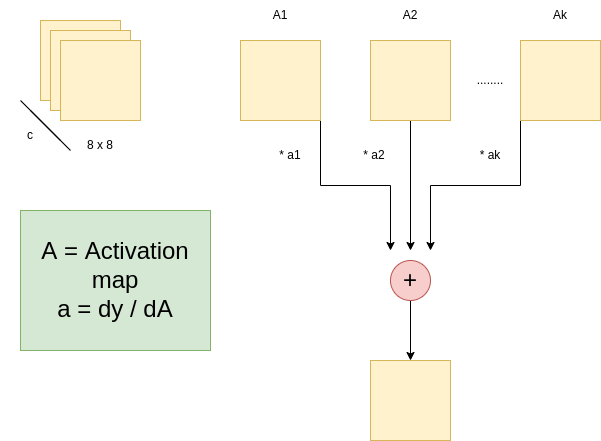

In [45]:
def get_gradcam(model, image, label, size):

  label.backward()
  gradients = model.get_activations_gradients()
  pooled_gradients = torch.mean(gradients, dim =[0,2,3])
  activations = model.get_activation(image).detach()
  
  for i in range(activations.shape[1]):
    activations[:,i,:,:] *= pooled_gradients[i]
  
  heatmap = torch.mean(activations, dim =1).squeeze().cpu()
  heatmap = nn.ReLU()(heatmap)
  heatmap /=torch.max(heatmap)
  heatmap = cv2.resize(heatmap.numpy(), (size, size))
  return heatmap




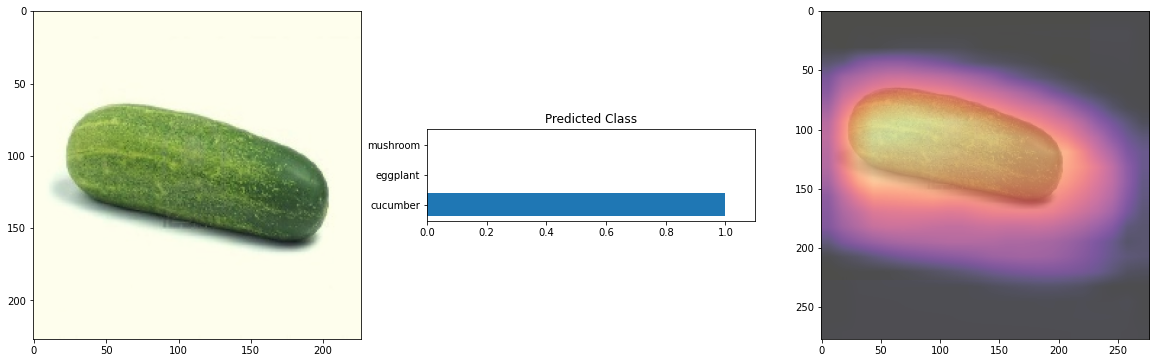

In [48]:
image, label = validset[7]

denorm_image = image.permute(1,2,0) * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
image = image.unsqueeze(0).to(DEVICE)

pred = model(image)
heatmap = get_gradcam(model, image, pred[0][0], size = 277)
utils.plot_heatmap(denorm_image, pred, heatmap)

